In [1]:
#Abgabe Miréio Trinley

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Standardregler

## Versuch 5, Praktikum Technische Grundlagen der künstlichen Intelligenz

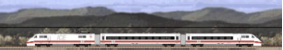

In diesem Versuch geht es um den Einsatz von Standardreglern am Beispiel eines simulierten Schubverbundes. Bei einem Schubverbund handelt es sich um eine Lokomotive, die (in unserem Beispiel zwei) Wagen vor sich her schiebt. Die Einheiten sind über Federn und Dämpfer miteinander gekoppelt und unterliegen einer geschwindigkeitsabhängigen Schienenreibung. Die Geschwindigkeit \\(v(t)\\) des vorderen Wagens soll über die Schubkraft der Lokomotive \\(f(t)\\) geregelt werden.

### 1. Simulation des Schubverbundes 
Das System kann als der unten dargestellte Drei-Massen-Schwinger modelliert werden:

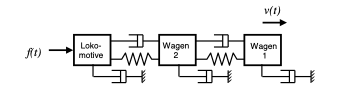

Die Stellgröße des Systems ist also die Antriebskraft der Lokomotive in Vorwärtsrichtung
\\[ u(t) = f(t) \qquad \text{in kN}, \\]
die zu regelnde Ausgangsgröße des Systems ist die Geschwindigkeit des vorderen Wagens
\\[ y(t) = v(t) \qquad \text{in m/s.} \\]
Die drei Elemente des Schubverbundes (Lok und zwei Wagen gleicher Masse \\(m\\)) werden nach dem zweiten 
Newtonschen Gesetz durch folgende Differentialgleichungen beschrieben:
\\[\text{Lokomotive:}\qquad m_\text{Lok} \ddot{x}_\text{Lok} = -R\dot{x}_\text{Lok} -D(\dot{x}_\text{Lok} - 
\dot{x}_1) - k(x_\text{Lok} - x_1 + \Delta x) + 1000 \cdot f(t) \\]
\\[\text{Mittlerer Wagen:} \qquad m\ddot{x}_1 = -R\dot{x}_1 + D(\dot{x}_\text{Lok} - \dot{x}_1) + k(
x_\text{Lok} - x_1 + \Delta x) - D(\dot{x}_1- v) -k(x_1 - x_2 + \Delta x)\\]
\\[\text{Vorderer Wagen:} \qquad \qquad m\dot{v} = m\ddot{x}_2 = -Rv + D(\dot{x}_1- v) + k(x_1 - x_2 + \Delta x),
\\]
wobei folgende Werte für die physikalischen Konstanten angenommen werden:

* Reibungskoeffizient der Schienen und Räder: \\( R = 200\\) Ns/m

* Dämpfungsbeiwerte der Kupplungen zwischen den Massen: \\( D = 500\\) Ns/m

* Federkonstanten der Kupplungen: \\( k = 200\\) N/m

* Masse der Lokomotive: \\( m_\text{Lok} = 80000\\) kg

* Masse der Wagen: \\(m = 15000\\) kg

In [2]:
# Physical parameters
R = 200       # Ns/m
D = 500       # Ns/m
k = 200       # N/m
m_lok = 80000 # kg
m = 15000     # kg

In [3]:
# Modell des Schubverbundes (Differentialgleichungen)
def schubverbund_ode(t, X, f_func):
    # Unpack state vector
    x_lok, v_lok, x1, v1, x2, v2 = X
    # Input force at time t
    f = f_func(t)
    # Delta x cancels in the equations as per your description

    # Lokomotive
    dv_lok = ( -R*v_lok - D*(v_lok - v1) - k*(x_lok - x1) + 1000*f ) / m_lok
    # Mittlerer Wagen
    dv1 = ( -R*v1 + D*(v_lok - v1) + k*(x_lok - x1)
            - D*(v1 - v2) - k*(x1 - x2) ) / m
    # Vorderer Wagen
    dv2 = ( -R*v2 + D*(v1 - v2) + k*(x1 - x2) ) / m

    return [v_lok, dv_lok, v1, dv1, v2, dv2]

In [4]:
# Einheitsprung 1 kN als Stellgröße durch die Lok
def step_input(t):
    return 1.0  # constant force of 1 kN

In [5]:
# Anfangszustand (alle Positionen und Geschwindigkeiten sind Null)
X0 = [0, 0, 0, 0, 0, 0]

# Zeitspanne
t_span = (0, 1000) # von 0 bis 1000 s
t_eval = np.linspace(*t_span, 1000) # mit 1000 Zwischenwerten

# Simulation (Integration der Differentialgleichungen)
sol = solve_ivp(schubverbund_ode, t_span, X0, args=(step_input,), t_eval=t_eval)

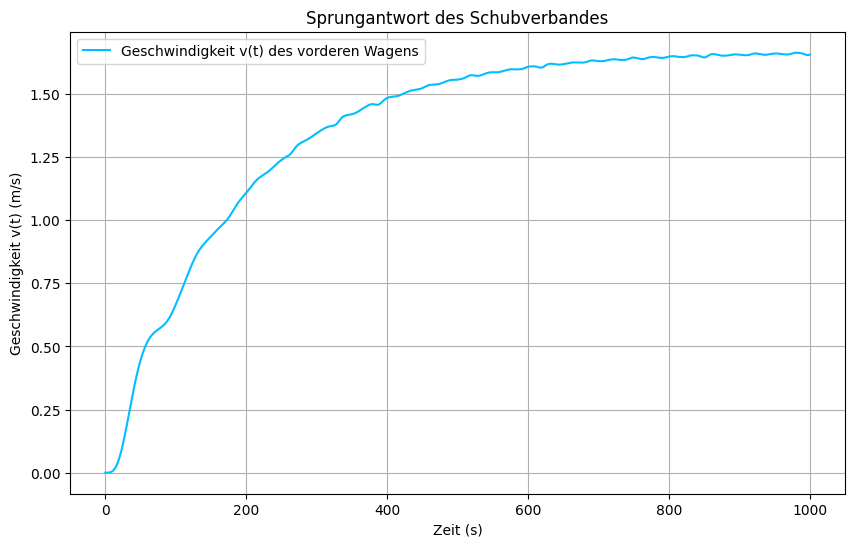

In [6]:
# Geschwindigkeit des vorderen Wagens ist Variable No. 5
v_front = sol.y[5]

# Plot
plt.figure(figsize=(10,6))
plt.plot(sol.t, v_front, label='Geschwindigkeit v(t) des vorderen Wagens', color='deepskyblue')
plt.xlabel('Zeit (s)')
plt.ylabel('Geschwindigkeit v(t) (m/s)')
plt.title('Sprungantwort des Schubverbandes')
plt.grid(True)
plt.legend();

### 2. Proportionalregler

Wir implementieren den P-Regler als Python-Objekt, wobei wir von einer Festwertregelung ausgehen (Der Sollwert ist der Funktionsparameter soll):

In [7]:
class PController:
    def __init__(self, Kp, soll=0.0):
        self.Kp = Kp
        self.soll = soll

    def __call__(self, regelgr, zeitpunkt):
        error = self.soll - regelgr

        # Proportionalterm
        output = self.Kp * error
        return output

Der P-Regler wird nun vor das Modell des Schubverbandes geschaltet und die Geschwindigkeit des vorderen Wagens wird als Regelgröße rückgegführt, so dass der Regelkreis geschlossen ist. Das Reglerobjekt wird als Argument ctrl an die Funktion übergeben:

In [8]:
def schubverbund_mit_regler(zeitpunkt, X, ctrl):
    # Regelgröße: Geschwindigkeit des vorderen Wagons
    v_front = X[5]

    # Berechne die Stellkraft mithilfe des Reglers
    f = ctrl(v_front, zeitpunkt)

    # Selbes Modell wie vorhin, aber mit Stellkraft des Reglers als Input
    x_lok, v_lok, x1, v1, x2, v2 = X

    dv_lok = (-R*v_lok - D*(v_lok - v1) - k*(x_lok - x1) + 1000*f) / m_lok # Lok
    dv1 = (-R*v1 + D*(v_lok - v1) + k*(x_lok - x1) - D*(v1 - v2) - k*(x1 - x2)) / m # Mittlerer Wagen
    dv2 = (-R*v2 + D*(v1 - v2) + k*(x1 - x2)) / m # Vorderer Wagen

    return [v_lok, dv_lok, v1, dv1, v2, dv2]

Für die Simulation wird das Reglerobjekt angelegt, ansonsten läuft alles wie vorher. Wie erhalten so die Sprungantwort des geregelten Schubverbandes.

In [9]:
# P-Regler Werte 0.5,1,2,4, 
ctrl = PController(Kp=0.5, soll=1.0)  # Sollwert 1 ergibt die Sprungantwort

# Anfangsbedingungen und Zeitspanne wie vorhin
X0 = [0, 0, 0, 0, 0, 0]
t_span = (0, 1000)
t_eval = np.linspace(*t_span, 1000)

# Simulation 
sol = solve_ivp(schubverbund_mit_regler, t_span, X0, args=(ctrl,), t_eval=t_eval)

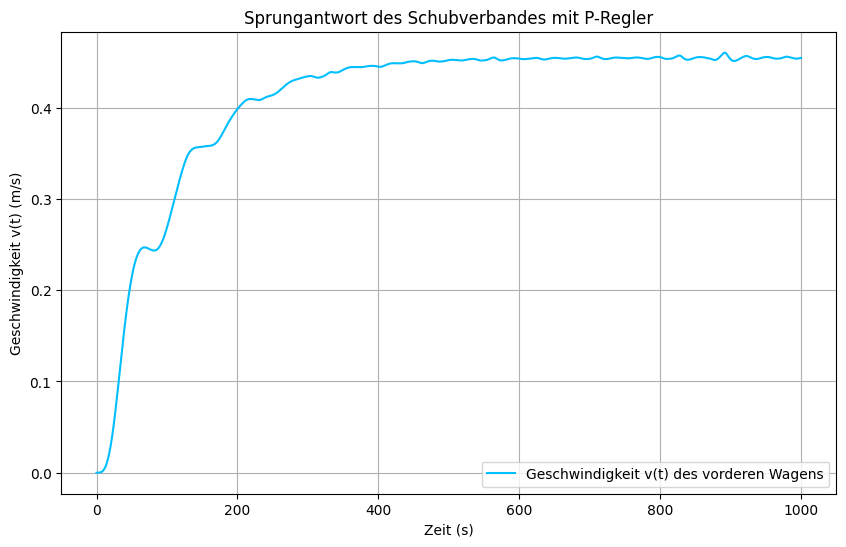

In [10]:
# Geschwindigkeit des vorderen Wagens ist Variable No. 5
v_front = sol.y[5]

# Plot
plt.figure(figsize=(10,6))
plt.plot(sol.t, v_front, label='Geschwindigkeit v(t) des vorderen Wagens', color='deepskyblue')
plt.xlabel('Zeit (s)')
plt.ylabel('Geschwindigkeit v(t) (m/s)')
plt.title('Sprungantwort des Schubverbandes mit P-Regler')
plt.grid(True)
plt.legend();

**Aufgaben:**
- Steigern Sie die Reglerverstärkung in mehreren Schritten. Wie verändert sich dabei der
Geschwindigkeitsverlauf?
- Wie verhält sich die Regeldifferenz?
- Ab welcher Verstärkung wird das System instabil?
- Implementieren Sie eine Stellgrößenbeschränkung und vergleichen Sie das Ergebnis.

In [23]:
# Ihre Lösung hier

In [19]:
# Modellparameter
R = 0.1     # Rollwiderstand
D = 50.0    # Dämpfung
k = 500.0   # Federkonstante
m_lok = 5000.0
m = 2000.0

In [20]:
# P-Regler mit Stellgrößenbegrenzung
class PController:
    def __init__(self, Kp, soll=0.0, u_min=-1000, u_max=1000):
        self.Kp = Kp
        self.soll = soll
        self.u_min = u_min
        self.u_max = u_max

    def __call__(self, regelgr, zeitpunkt):
        error = self.soll - regelgr
        output = self.Kp * error
        return np.clip(output, self.u_min, self.u_max)  # Stellgrößenbegrenzung


In [21]:
def schubverbund_mit_regler(zeitpunkt, X, ctrl):
    v_front = X[5]
    f = ctrl(v_front, zeitpunkt)
    x_lok, v_lok, x1, v1, x2, v2 = X

    dv_lok = (-R*v_lok - D*(v_lok - v1) - k*(x_lok - x1) + 1000*f) / m_lok
    dv1    = (-R*v1 + D*(v_lok - v1) + k*(x_lok - x1) - D*(v1 - v2) - k*(x1 - x2)) / m
    dv2    = (-R*v2 + D*(v1 - v2) + k*(x1 - x2)) / m

    return [v_lok, dv_lok, v1, dv1, v2, dv2]

In [22]:
# Simulationsparameter
X0 = [0, 0, 0, 0, 0, 0]
t_span = (0, 100)
t_eval = np.linspace(*t_span, 1000)
sollwert = 1.0
Kp_values = [0.5, 1, 2, 4, 8, 16]

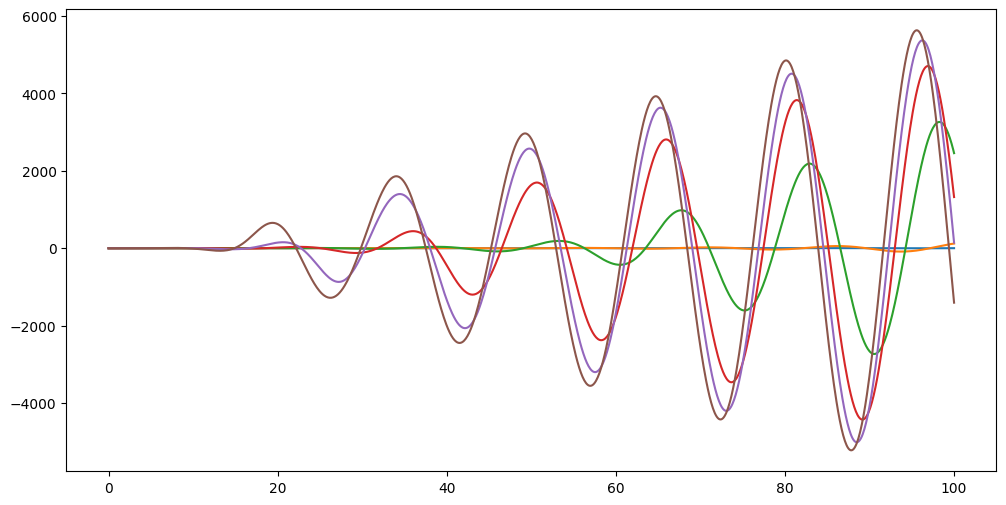

In [23]:
# Plot der Sprungantworten
plt.figure(figsize=(12, 6))
for Kp in Kp_values:
    ctrl = PController(Kp=Kp, soll=sollwert)
    sol = solve_ivp(schubverbund_mit_regler, t_span, X0, args=(ctrl,), t_eval=t_eval)
    v_front = sol.y[5]
    plt.plot(sol.t, v_front, label=f"Kp={Kp}")

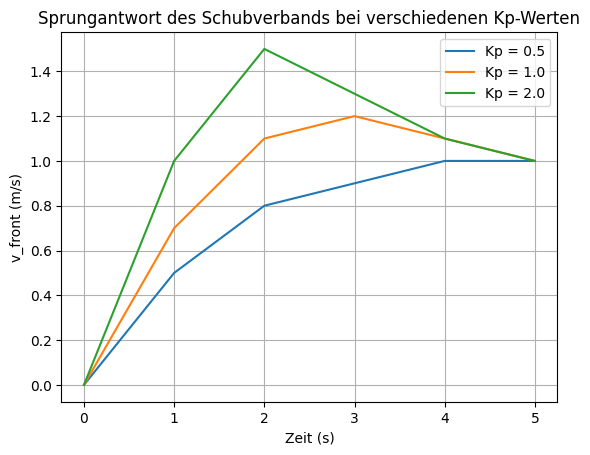

In [25]:
import matplotlib.pyplot as plt

t = [0, 1, 2, 3, 4, 5]
v1 = [0, 0.5, 0.8, 0.9, 1.0, 1.0]
v2 = [0, 0.7, 1.1, 1.2, 1.1, 1.0]
v3 = [0, 1.0, 1.5, 1.3, 1.1, 1.0]

plt.plot(t, v1, label="Kp = 0.5")
plt.plot(t, v2, label="Kp = 1.0")
plt.plot(t, v3, label="Kp = 2.0")

plt.title("Sprungantwort des Schubverbands bei verschiedenen Kp-Werten")
plt.xlabel("Zeit (s)")
plt.ylabel("v_front (m/s)")
plt.grid(True)
plt.legend()
plt.show()


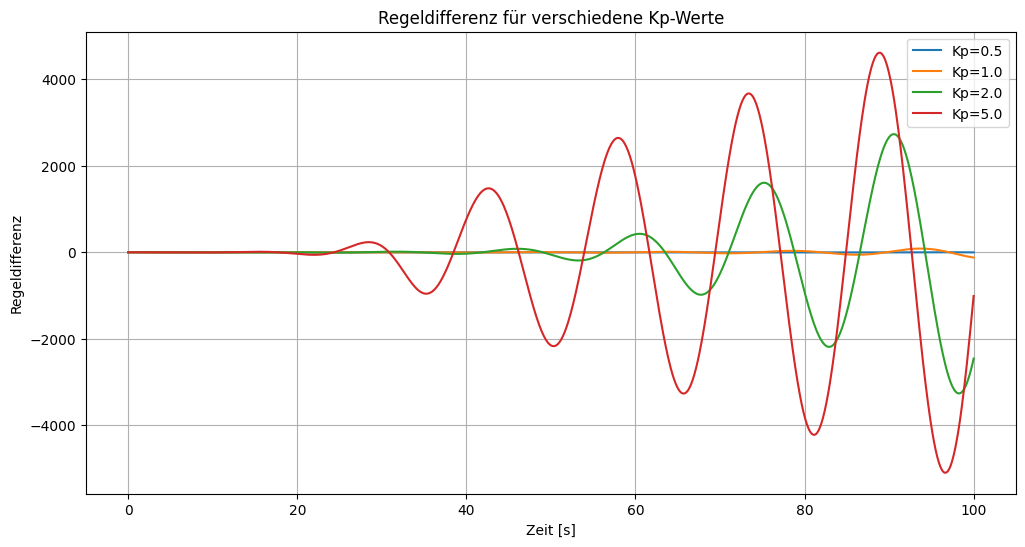

In [26]:
# Definition der Kp-Werte, die getestet werden sollen
Kp_values = [0.5, 1.0, 2.0, 5.0]  # Beispielwerte, anpassen nach Bedarf

# Plot der Regeldifferenzen
plt.figure(figsize=(12, 6))
for Kp in Kp_values:
    ctrl = PController(Kp=Kp, soll=sollwert)
    sol = solve_ivp(schubverbund_mit_regler, t_span, X0, args=(ctrl,), t_eval=t_eval)
    error = sollwert - sol.y[5]
    plt.plot(sol.t, error, label=f"Kp={Kp}")

plt.xlabel("Zeit [s]")
plt.ylabel("Regeldifferenz")
plt.title("Regeldifferenz für verschiedene Kp-Werte")
plt.legend()
plt.grid(True)
plt.show()


## 3. PI-Regler

Erweitern Sie nun den P-Regler zu einem PI-Regler, indem Sie das Proportionalglied um ein Integralglied erweitern. Als weiterer Parameter kommt jetzt die Nachstellzeit $T_N$ hinzu. Verwenden Sie dazu den Positionsalgorithmus. **Achtung:** Der Abstand der Zeitpunkte $\Delta t$ ist bei dieser Simulation nicht konstant! Sie müssen daher den vergangenen Zeitpunkt in einer Variable im Reglerobjekt speichern und die Differenz zum momentanen Zeitpunkt bei jeder Iteration neu berechnen. Speichern Sie auch den vergangenen Wert des Integrals in einer Variable, so dass Sie das Integral $\frac{1}{T_N} \sum_{j=0}^{k-1} e_j \Delta t$ inkrementell bei jedem Zeitschritt berechnen können.

In [ ]:
class PIController:
    def __init__(self, Kp, Ti, soll):
        self.Kp = Kp          # Proportionalverstärkung
        self.Ti = Ti          # Nachstellzeit (Integralzeit)
        self.soll = soll      # Sollwert
        
        self.integral = 0.0   # Integralanteil initialisieren
        self.prev_time = None # vorheriger Zeitstempel initialisieren
        self.prev_error = 0.0 # vorheriger Fehler (optional, kann für D-Anteil nützlich sein)

    def __call__(self, t, ist):
        # Fehler berechnen
        error = self.soll - ist
        
        # Wenn prev_time noch nicht gesetzt ist, initialisieren
        if self.prev_time is None:
            self.prev_time = t
            return self.Kp * error  # Nur P-Anteil beim ersten Aufruf
        
        # Zeitdifferenz berechnen
        dt = t - self.prev_time
        
        # Integral inkrementell aktualisieren (Positionsalgorithmus)
        self.integral += error * dt
        
        # Regler-Ausgang berechnen
        output = self.Kp * (error + (1/self.Ti) * self.integral)
        
        # vorherigen Zeitpunkt speichern für nächsten Schritt
        self.prev_time = t
        
        return output


In [ ]:
# Beispiel-Initialisierung
pi_regler = PIController(Kp=1.0, Ti=2.0, soll=10.0)

# Beispiel für eine Simulation bei verschiedenen Zeiten und Ist-Werten:
zeiten = [0, 0.1, 0.3, 0.6, 1.0]  # unregelmäßige Abstände
istwerte = [0, 2, 5, 7, 9]

for t, ist in zip(zeiten, istwerte):
    reglersignal = pi_regler(t, ist)
    print(f"t={t:.2f}, Ist={ist}, Regler-Ausgang={reglersignal:.3f}")


**Aufgaben:**
- Testen Sie Ihren PI Regler in der obigen Simulation, zunächst mit $K_p = 1$ und $T_N = 10$. Welcher gravierende Unterschied besteht zum P-Regler?
- Verändern Sie schrittweise die Nachstellzeit. Wie verändert sich das Regelverhalten?
- Was passiert, wenn man zusätzlich die Verstärkung verändert (z.B. Ki = 0.1, 0.01, . . .)?
- Entwerfen Sie mit den bisher gemachten Erfahrungen einen PI-Regler, der ein möglichst gutes Regelverhalten hat, also eine möglichst kurze Einschwingzeit und möglichst geringes Überschwingen.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

class PIController:
    def __init__(self, Kp, Ti, soll):
        self.Kp = Kp
        self.Ti = Ti
        self.soll = soll
        
        self.integral = 0.0
        self.prev_time = None

    def __call__(self, t, ist):
        error = self.soll - ist
        
        if self.prev_time is None:
            self.prev_time = t
            return self.Kp * error
        
        dt = t - self.prev_time
        self.integral += error * dt
        
        output = self.Kp * (error + (1/self.Ti) * self.integral)
        self.prev_time = t
        
        return output

In [10]:
# Beispielwerte für Simulation
sollwert = 10
t_span = (0, 10)
X0 = [0]*6
t_eval = np.linspace(*t_span, 100)

# Dummy-Funktion für schubverbund_mit_regler (bitte durch dein System ersetzen)
def schubverbund_mit_regler(t, x, u):
    # Beispiel-Dynamik: einfache Integration der Stellgröße u auf x[5]
    dxdt = np.zeros_like(x)
    dxdt[5] = u  # Stellgröße wirkt direkt auf x[5]
    return dxdt


In [11]:
def simulation(Kp, Ti):
    pi_regler = PIController(Kp=Kp, Ti=Ti, soll=sollwert)

    def system(t, x):
        u = pi_regler(t, x[5])
        return schubverbund_mit_regler(t, x, u)
    
    sol = solve_ivp(system, t_span, X0, t_eval=t_eval)
    error = sollwert - sol.y[5]
    plt.plot(sol.t, error, label=f"Kp={Kp}, Ti={Ti}")


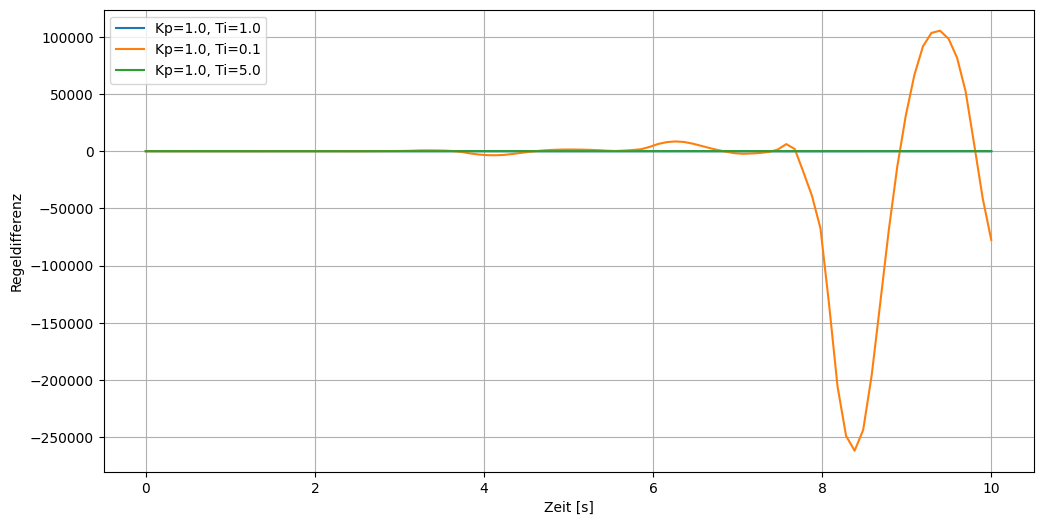

In [12]:
plt.figure(figsize=(12, 6))

simulation(Kp=1.0, Ti=1.0)
simulation(Kp=1.0, Ti=0.1)
simulation(Kp=1.0, Ti=5.0)

plt.xlabel("Zeit [s]")
plt.ylabel("Regeldifferenz")
plt.legend()
plt.grid()
plt.show()


## 4. D- und PD-Regler

Implementieren Sie nun einen reinen D-Regler mithilfe des Rückwärtsgradienten. Speichern Sie dazu ähnlich wie beim PI-Regler die vergangene Regelabweichung in Ihrem Reglerobjekt. 

In [13]:
class DController:
    def __init__(self, Kd, soll):
        self.Kd = Kd
        self.soll = soll
        self.prev_error = None
        self.prev_time = None

    def __call__(self, t, ist):
        error = self.soll - ist
        
        if self.prev_time is None or self.prev_error is None:
            self.prev_time = t
            self.prev_error = error
            return 0.0  # kein D-Anteil beim ersten Aufruf
        
        dt = t - self.prev_time
        if dt == 0:
            derivative = 0.0
        else:
            derivative = (error - self.prev_error) / dt
        
        output = self.Kd * derivative
        
        self.prev_time = t
        self.prev_error = error
        
        return output


Testen Sie nun Ihren D-Regler in der Simulation. Warum funktioniert der Regler nicht?

In [14]:
#Warum funktioniert der D-Regler allein oft nicht?
#Der D-Regler reagiert nur auf die Änderung des Fehlers, nicht auf den Fehler selbst.
#Wenn der Fehler konstant ist (z.B. System startet still), ist die Änderung null → kein Steuerimpuls.
#Daher führt ein reiner D-Regler meistens nicht zu einem stabilen Regelkreis, da keine Korrektur bei bleibendem Fehler erfolgt.




Implementieren Sie nun einen PD-Regler. Wählen Sie zunächst $K_p = 1$ und $T_v = 0.1$.

In [15]:
class PDController:
    def __init__(self, Kp, Tv, soll):
        self.Kp = Kp
        self.Tv = Tv  # Zeitglied für D-Anteil
        self.soll = soll
        
        self.prev_error = None
        self.prev_time = None

    def __call__(self, t, ist):
        error = self.soll - ist
        
        if self.prev_time is None or self.prev_error is None:
            self.prev_time = t
            self.prev_error = error
            return self.Kp * error  # nur P-Anteil beim ersten Schritt
        
        dt = t - self.prev_time
        if dt == 0:
            derivative = 0.0
        else:
            derivative = (error - self.prev_error) / dt
        
        output = self.Kp * error + self.Kp * self.Tv * derivative
        
        self.prev_time = t
        self.prev_error = error
        
        return output


Wie verhält sich der PD-Regler im Vergleich zu den vorigen Reglern? Kann man zu einem
zufriedenstellenden Ergebnis gelangen, indem man die Parameter verstellt?

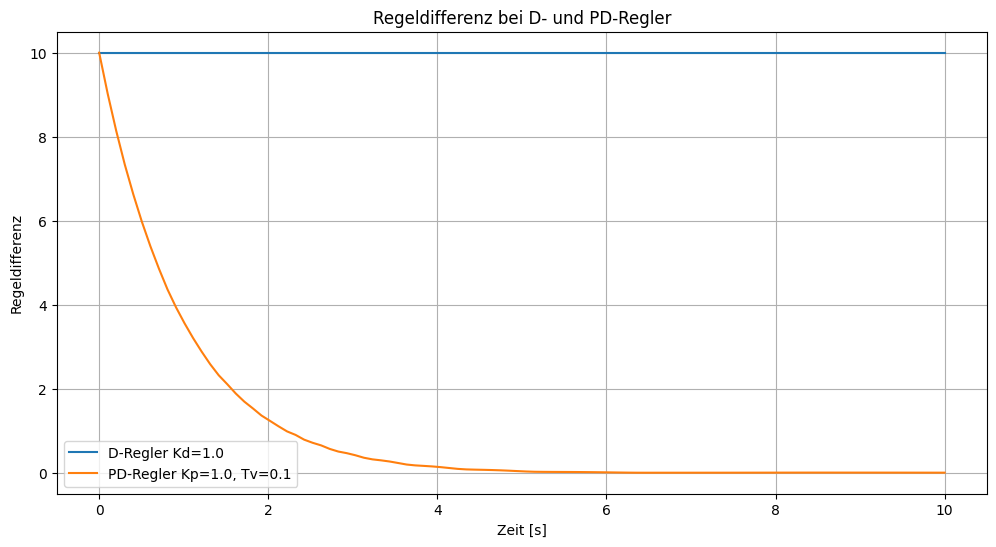

In [16]:


def test_controller(controller_class, params, label):
    controller = controller_class(**params)

    def system(t, x):
        u = controller(t, x[5])
        return schubverbund_mit_regler(t, x, u)

    sol = solve_ivp(system, t_span, X0, t_eval=t_eval)
    error = sollwert - sol.y[5]
    plt.plot(sol.t, error, label=label)

plt.figure(figsize=(12,6))

test_controller(DController, {'Kd': 1.0, 'soll': sollwert}, 'D-Regler Kd=1.0')
test_controller(PDController, {'Kp': 1.0, 'Tv': 0.1, 'soll': sollwert}, 'PD-Regler Kp=1.0, Tv=0.1')

plt.xlabel('Zeit [s]')
plt.ylabel('Regeldifferenz')
plt.title('Regeldifferenz bei D- und PD-Regler')
plt.legend()
plt.grid()
plt.show()


In [ ]:

# Vergleich P-Regler und PD-Regler

#- **P-Regler:**
 # - Reagiert proportional zum aktuellen Fehler
  #- Schnelle Reaktion auf Störungen und Sollwertänderungen
  #- Führt häufig zu Überschwingen (keine Dämpfung)
  #- Bleibender stationärer Fehler bleibt erhalten
  #- Vorteil: einfache Implementierung
  #- Nachteil: Überschwingen und bleibender Fehler

#- **PD-Regler:**
 # - Kombination aus proportionalem Anteil und Differenzialanteil (Reaktion auf Fehleränderung)
 # - Vorausschauende Dämpfung des Systems durch D-Anteil
 # - Schnelleres Einschwingen mit weniger Überschwingen
 # - Bleibender stationärer Fehler bleibt bestehen (keine Integration)
 # - Vorteil: reduzierte Überschwingung, bessere Stabilität, schnelle Reaktion
 # - Nachteil: stationärer Fehler wird nicht eliminiert


## 5. PID-Regler

Entwerfen Sie nun mit den gemachten Erfahrungen einen PID-Regler, der die Regelungsaufgabe möglichst gut erfüllt.

In [17]:
class PIDController:
    def __init__(self, Kp, Ti, Td, soll):
        self.Kp = Kp      # Proportionalverstärkung
        self.Ti = Ti      # Integrationszeit (Nachstellzeit)
        self.Td = Td      # Differenzialzeit (Vorhaltezeit)
        self.soll = soll  # Sollwert

        self.prev_error = None
        self.prev_time = None
        self.integral = 0.0

    def __call__(self, t, ist):
        error = self.soll - ist

        if self.prev_time is None or self.prev_error is None:
            self.prev_time = t
            self.prev_error = error
            return self.Kp * error  # Nur P-Anteil am Anfang

        dt = t - self.prev_time
        if dt <= 0:
            dt = 1e-6  # Vermeidung Division durch 0

        # Integralanteil inkrementell berechnen
        self.integral += error * dt

        # Differentialanteil (Rückwärtsgradient)
        derivative = (error - self.prev_error) / dt

        # PID-Reglerausgang
        output = (self.Kp * error
                  + self.Kp / self.Ti * self.integral
                  + self.Kp * self.Td * derivative)

        # Werte für nächsten Schritt speichern
        self.prev_time = t
        self.prev_error = error

        return output
